In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import yaml
from typing import *
import matplotlib.pyplot as plt

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Row, Window

In [77]:
base_path = "/data/saturation/ir_random_1/1.884_0.250_4.333_3.708"

n_cores = 8

In [52]:
spark = SparkSession.builder \
                    .master(f"local[{n_cores}]") \
                    .appName("Saturation") \
                    .config("spark.driver.memory", "32g") \
                    .getOrCreate()
sc = spark.sparkContext

In [78]:
min_x = 500
max_x = 4500
min_y = 500
max_y = 4500

craters = spark.read.format("parquet").load([f"{base_path}/craters_*.parquet"])
craters.createOrReplaceTempView("all_craters")

craters = craters.where(craters.x.between(min_x, max_x)).where(craters.y.between(min_y, max_y))
window = Window.orderBy("id")
craters = craters.withColumn("N", F.row_number().over(window))
craters.createOrReplaceTempView("craters_in_study_region")

removals = spark.read.parquet(f"{base_path}/crater_removals_*.parquet")
removals.createOrReplaceTempView("removals")

In [79]:
max_N = 100000

query = f"""
SELECT
    c1.N,
    c1.id,
    c1.radius
FROM
    craters_in_study_region c1
    LEFT JOIN removals r
        ON r.removed_crater_id = c1.id
    LEFT JOIN all_craters c2
        ON c2.id = r.removed_by_crater_id
WHERE
    c1.N <= {max_N}
    AND (c2.id IS NULL OR c2.id <= 
        (
            SELECT
                MAX(id)
            FROM
                craters_in_study_region
            WHERE
                N <= {max_N}
        )
    )
ORDER BY
    c1.N
"""

df = spark.sql(query).toPandas()

23/09/12 21:04:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/12 21:04:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/12 21:04:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/12 21:04:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/12 21:04:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/12 21:04:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/12 2

In [80]:
df

,N,id,radius
0,1,524,5.052048
1,2,721,5.403654
2,3,1604,8.696503
3,4,1817,5.018136
4,5,2433,8.135170
...,...,...,...
65155,99174,35607862,6.776742
65156,99256,35632552,5.047503
65157,99354,35667164,6.338941
65158,99520,35727035,5.763909


In [88]:
def plot_sfds(data: pd.DataFrame, slope: float, times: List[int]):
    # Track min and max radii
    min_radius = 1e10
    max_radius = 0
    
    for time in times:
        state_at_time = data[data.N <= time]
        radii = state_at_time.radius.sort_values()
        
        min_r = radii.head(1).squeeze()
        max_r = radii.tail(1).squeeze()
        if min_r < min_radius:
            min_radius = min_r
        if max_r > max_radius:
            max_radius = max_r
        
        plt.plot(radii, range(len(radii) + 1, 1, -1), label=time)

    # Plot geometric saturation lines
    saturation_range = np.array(range(int(min_radius), int(max_radius)))
    saturation_vals = np.array([4000**2 / (np.pi * x**2) for x in saturation_range])
    plt.plot(saturation_range, saturation_vals/10, 'b--', label="10% Sat")
    plt.plot(saturation_range, saturation_vals/100, 'r--', label="1% Sat")
    
    # Plot production lines
    production_vals = np.array([x**-slope for x in saturation_range])
    # plt.plot(saturation_range, production_vals * 1e5, 'g--', label="Prod 1e5")
    plt.plot(saturation_range, production_vals * 1e6, 'g--', label="Prod 1e6")
    plt.plot(saturation_range, production_vals * 1e7, 'g--', label="Prod 1e7")
    plt.plot(saturation_range, production_vals * 1e8, 'g--', label="Prod 1e8")
    
    plt.subplots_adjust(right=0.7)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

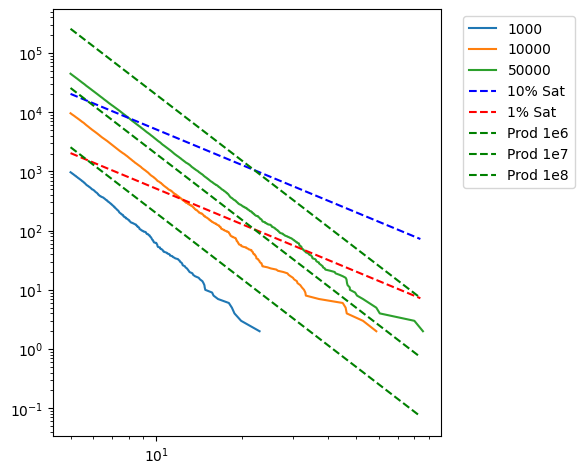

In [96]:
slope = 3.708
plot_sfds(df, slope, [1000, 10000, 50000])

In [92]:
craters.select(F.max(craters.radius)).toPandas()

,max(radius)
0,224.045654


In [ ]:
craters.count()